In [1]:
library('readr')
library('magrittr')
library('dplyr')
library('tidyr')
library('ggplot2')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [13]:
counts <-
    read_tsv(
        'pbmc-counts.tsv',
        col_types=cols(
          `Replicate`=col_factor(levels=c('R1', 'R2', 'R3')),
          `Count`=col_factor(levels=c("1", "2")),
          `IL2`=col_factor(levels=c("-", "200 U/mL")),
          `Activation bead`=col_factor(levels=c("-", "1:1")),
          `Live cells per ml`=col_double(),
          `Live cell fraction`=col_double()
        )
    ) %>%
    group_by(`IL2`, `Activation bead`) %>%
    summarize(
        `Cell_count_avg`=mean(`Live cells per ml`),
        `Cell_count_sd`=sd(`Live cells per ml`),
        `Live_percent_avg`=mean(`Live cell fraction`) * 100,
        `Live_percent_sd`=sd(`Live cell fraction`) * 100
    )

counts

IL2,Activation bead,Cell_count_avg,Cell_count_sd,Live_percent_avg,Live_percent_sd
-,-,91883.33,47535.73,70.50000,19.149413
200 U/mL,-,145500.00,11184.81,44.33333,7.916228
200 U/mL,1:1,856333.33,94677.70,65.50000,4.415880


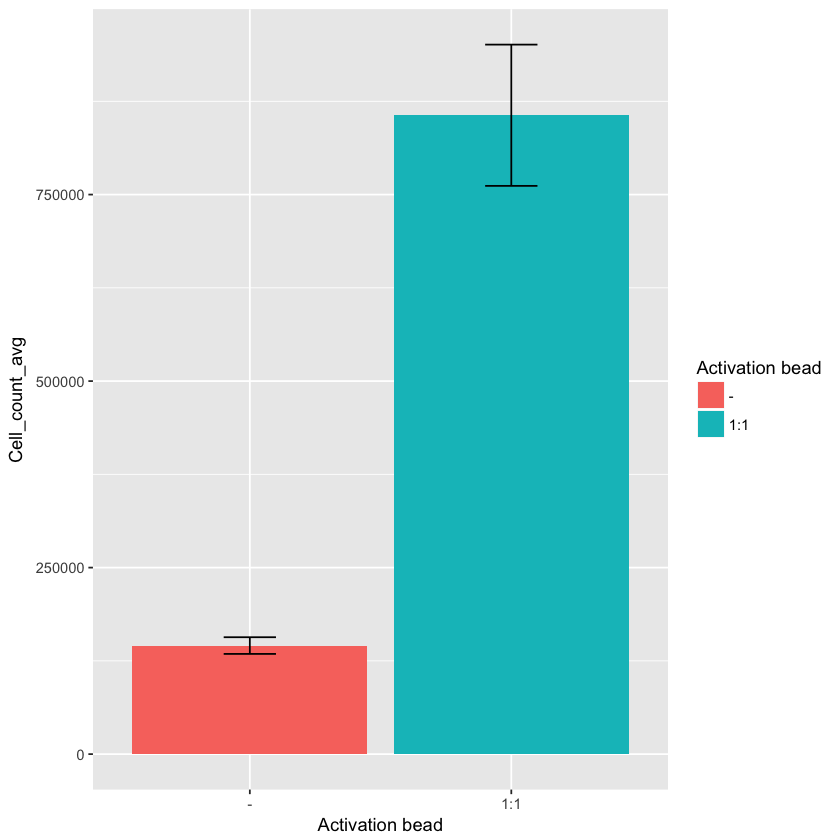

In [27]:
counts %>%
    filter(`IL2` != "-") %>%
    ggplot(aes(x=`Activation bead`, y=`Cell_count_avg`, fill=`Activation bead`)) +
    geom_col() +
    geom_errorbar(
        aes(ymin=`Cell_count_avg`-`Cell_count_sd`, ymax=`Cell_count_avg`+`Cell_count_sd`),
        width=0.2
    ) 

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'Bead:cell ratio' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(capture.output(print(obj)), collapse = "\n")
10. capture.output(print(obj))
11. evalVis(expr)
12. withVisible(eval(expr, pf))
13. eval(expr, pf)
14. eval(expr, pf)
15. print(obj)
16. print.ggplot(obj)
17. ggplot_build(x)
18. by_layer(function(l, d)

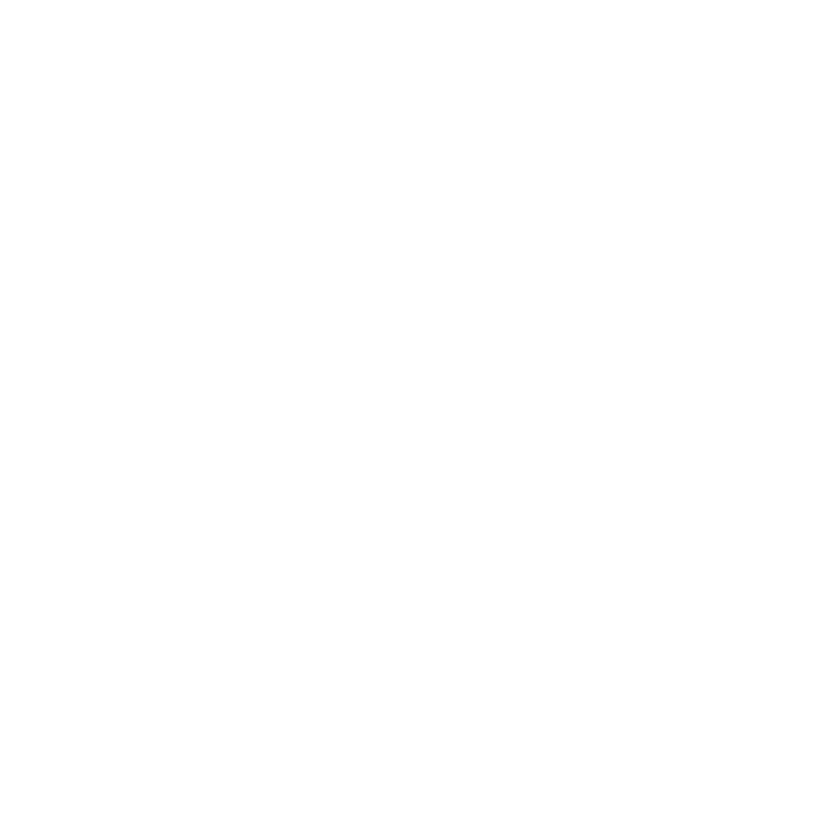

In [39]:
cd348_grp <-
    read_tsv(
        'pbmc-cd3.tsv',
        col_types=cols(
            `Sample:` = col_character(),
            `IL2`=col_factor(levels=c("-", "200 U/mL")),
            `Activation beads`=col_factor(levels=c("-", "1:1")),
            .default=col_double()
        )
    ) %>%
    filter(`IL2` != "-") %>%
    group_by(`Activation beads`)

rbind(
    cd348_grp %>%
    summarize(
        `Freq_mean`=mean(`Live/CD3+ | Freq. of Parent`),
        `Freq_sd`=sd(`Live/CD3+ | Freq. of Parent`)
    ) %>%
    mutate(`Population`="CD3+"),
    cd348_grp %>%
    summarize(
        `Freq_mean`=mean(`Live/CD3+/CD4+ CD8- | Freq. of Parent`),
        `Freq_sd`=sd(`Live/CD3+/CD4+ CD8- | Freq. of Parent`),        
    ) %>%
    mutate(`Population`="CD3+ CD4+"),
    cd348_grp %>%
    summarize(
        `Freq_mean`=mean(`Live/CD3+/CD4- CD8+ | Freq. of Parent`),
        `Freq_sd`=sd(`Live/CD3+/CD4- CD8+ | Freq. of Parent`)
    ) %>%
    mutate(`Population`="CD3+ CD8+")
) %>%
mutate(`Population`=factor(`Population`)) %>%
ggplot(aes(x=`Activation beads`, y=`Freq_mean`, fill=`Bead:cell ratio`)) +
    geom_col() +
    geom_errorbar(
            aes(ymin=`Freq_mean`-`Freq_sd`, ymax=`Freq_mean`+`Freq_sd`),
            width=0.2
    ) +
    facet_wrap(~Population) +
    ylim(0, 100) +
    ylab('Percent population (%)')
